In [1]:

%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')
from jobpostlib import (cu, datetime, duration, freq, hau, humanize, nu, scrfcu, slrcu, su, t0, time, wsu, speech_engine)
import os
from pandas import DataFrame

Pretty printing has been turned OFF
======== Neo4j/4.4.7 ========
Utility libraries created in 9 seconds


In [2]:

[fn for fn in dir(nu) if 'data' in fn]

['convert_to_data_frame', 'data_csv_folder', 'data_folder', 'data_models_folder', 'get_regexed_dataframe', 'get_wiki_infobox_data_frame', 'load_data_frames', 'save_data_frames']

In [3]:

cypher_str = f'''
// Find the navigable parents that are chained to another for each file name
MATCH (np1:NavigableParents)-[r1:NEXT]->(np2:NavigableParents)
RETURN
    
    np1.is_corporate_scope AS np1_is_corporate_scope,
    np1.is_interview_procedure AS np1_is_interview_procedure,
    np1.is_job_title AS np1_is_job_title,
    np1.is_supplemental_pay AS np1_is_supplemental_pay,
    np1.is_minimum_qualification AS np1_is_minimum_qualification,
    np1.is_other AS np1_is_other,
    np1.is_task_scope AS np1_is_task_scope,
    np1.is_educational_requirement AS np1_is_educational_requirement,
    np1.is_job_duration AS np1_is_job_duration,
    np1.navigable_parent AS np1_navigable_parent,
    np1.is_posting_date AS np1_is_posting_date,
    np1.is_office_location AS np1_is_office_location,
    np1.is_preferred_qualification AS np1_is_preferred_qualification,
    np1.is_legal_notification AS np1_is_legal_notification,
    np1.is_header AS np1_is_header,
    
    np2.is_corporate_scope AS np2_is_corporate_scope,
    np2.is_interview_procedure AS np2_is_interview_procedure,
    np2.is_job_title AS np2_is_job_title,
    np2.is_supplemental_pay AS np2_is_supplemental_pay,
    np2.is_minimum_qualification AS np2_is_minimum_qualification,
    np2.is_other AS np2_is_other,
    np2.is_task_scope AS np2_is_task_scope,
    np2.is_educational_requirement AS np2_is_educational_requirement,
    np2.is_job_duration AS np2_is_job_duration,
    np2.navigable_parent AS np2_navigable_parent,
    np2.is_posting_date AS np2_is_posting_date,
    np2.is_office_location AS np2_is_office_location,
    np2.is_preferred_qualification AS np2_is_preferred_qualification,
    np2.is_legal_notification AS np2_is_legal_notification,
    np2.is_header AS np2_is_header,
    
    r1.file_name AS next_file_name,
    r1.sequence_order AS next_sequence_order
    
LIMIT 10000;'''
row_objs_list = []
with cu.driver.session() as session: row_objs_list = session.write_transaction(cu.do_cypher_tx, cypher_str)
assert row_objs_list, "Rewrite your cypher so you get some output"

# Convert the Cypher query result to a Pandas DataFrame
df = DataFrame(row_objs_list)

# Create node features (Left NavigableParents, NEXT, and Right NavigableParents)
columns_list = [
    'np1_is_corporate_scope', 'np1_is_interview_procedure', 'np1_is_job_title', 'np1_is_supplemental_pay', 'np1_is_minimum_qualification', 'np1_is_other', 'np1_is_task_scope',
    'np1_is_educational_requirement', 'np1_is_job_duration', 'np1_navigable_parent', 'np1_is_posting_date', 'np1_is_office_location', 'np1_is_preferred_qualification',
    'np1_is_legal_notification', 'np1_is_header', 'np2_is_corporate_scope', 'np2_is_interview_procedure', 'np2_is_job_title', 'np2_is_supplemental_pay',
    'np2_is_minimum_qualification', 'np2_is_other', 'np2_is_task_scope', 'np2_is_educational_requirement', 'np2_is_job_duration', 'np2_navigable_parent', 'np2_is_posting_date',
    'np2_is_office_location', 'np2_is_preferred_qualification', 'np2_is_legal_notification', 'np2_is_header', 'next_file_name', 'next_sequence_order'
]

# Convert the feature columns to boolean
mask_series = df.columns.map(lambda x: '_is_' in x)
for cn in df.columns[mask_series]:
    df[cn] = df[cn].astype(bool)

# Convert the sequence order column to an integer column
df['next_sequence_order'] = df['next_sequence_order'].astype(int)

# Create a list of dictionaries representing each row of the result
query_result = df.to_dict(orient='records')

In [21]:

import torch
from torch_geometric.data import Data

# Step 1: Extract unique node features and assign a unique ID to each node
left_nodes = {}
right_nodes = {}
edges = []

for row in query_result:
    left_id = row['np1_navigable_parent']
    right_id = row['np2_navigable_parent']
    
    if left_id not in left_nodes:
        left_nodes[left_id] = {
            'is_corporate_scope': row['np1_is_corporate_scope'],
            'is_interview_procedure': row['np1_is_interview_procedure'],
            'is_job_title': row['np1_is_job_title'],
            'is_supplemental_pay': row['np1_is_supplemental_pay'],
            'is_minimum_qualification': row['np1_is_minimum_qualification'],
            'is_other': row['np1_is_other'],
            'is_task_scope': row['np1_is_task_scope'],
            'is_educational_requirement': row['np1_is_educational_requirement'],
            'is_job_duration': row['np1_is_job_duration'],
            'is_posting_date': row['np1_is_posting_date'],
            'is_office_location': row['np1_is_office_location'],
            'is_preferred_qualification': row['np1_is_preferred_qualification'],
            'is_legal_notification': row['np1_is_legal_notification'],
            'is_header': row['np1_is_header']
        }
    
    if right_id not in right_nodes:
        right_nodes[right_id] = {
            'is_corporate_scope': row['np2_is_corporate_scope'],
            'is_interview_procedure': row['np2_is_interview_procedure'],
            'is_job_title': row['np2_is_job_title'],
            'is_supplemental_pay': row['np2_is_supplemental_pay'],
            'is_minimum_qualification': row['np2_is_minimum_qualification'],
            'is_other': row['np2_is_other'],
            'is_task_scope': row['np2_is_task_scope'],
            'is_educational_requirement': row['np2_is_educational_requirement'],
            'is_job_duration': row['np2_is_job_duration'],
            'is_posting_date': row['np2_is_posting_date'],
            'is_office_location': row['np2_is_office_location'],
            'is_preferred_qualification': row['np2_is_preferred_qualification'],
            'is_legal_notification': row['np2_is_legal_notification'],
            'is_header': row['np2_is_header']
        }
    
    edges.append((left_id, right_id))

# Step 2: Create tensors for node features and edge indices
left_node_ids = list(left_nodes.keys())
np_node_ids = list(right_nodes.keys())
all_node_ids = left_node_ids + np_node_ids

node_id_map = {node_id: i for i, node_id in enumerate(all_node_ids)}

node_features = []
labels = []
for node_id in all_node_ids:
    if node_id in left_nodes:
        node_features.append(list(left_nodes[node_id].values()))
        labels.append(node_id)
    elif node_id in right_nodes:
        node_features.append(list(right_nodes[node_id].values()))
        labels.append([node_id])

node_features = torch.tensor(node_features, dtype=torch.float)

edge_indices = torch.tensor([[node_id_map[src], node_id_map[dst]] for src, dst in edges if dst in node_id_map], dtype=torch.long).t().contiguous()

# Create edge attributes (sequence order)
edge_attributes = df[['next_sequence_order']].values
edge_attributes = torch.tensor(edge_attributes)

# Step 3: Create the torch_geometric.data.Data object
data = Data(x=node_features, edge_index=edge_indices, edge_attr=edge_attributes)

# Compute the number of node features
num_node_features = data.x.shape[1]

# Compute the number of classes
num_classes = len(torch.unique(data.x))

In [23]:

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First GCN layer with ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        
        # Second GCN layer
        x = self.conv2(x, edge_index)
        
        return x

# Load and prepare data
# Assuming 'data' is already created and contains 'x', 'edge_index', and 'edge_attr'

# Compute the number of node features
num_node_features = data.x.shape[1]

# For demonstration purposes, we'll predict the same number of features as input features
num_classes = num_node_features

# Create the model
hidden_channels = 16  # You can adjust the hidden layer size
model = GCN(num_node_features, hidden_channels, num_classes)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()  # Using MSE loss for regression-like task

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.x)
    loss.backward()
    optimizer.step()
    return loss.item()

# Training loop
epochs = 200
for epoch in range(epochs):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# Save the trained model
torch.save(model.state_dict(), 'gcn_model.pth')

# Test the model (optional, if you have test data)
# model.eval()
# test_loss = criterion(model(test_data), test_data.x)
# print(f'Test Loss: {test_loss:.4f}')

Epoch 0, Loss: 0.0351
Epoch 10, Loss: 0.0218
Epoch 20, Loss: 0.0187
Epoch 30, Loss: 0.0155
Epoch 40, Loss: 0.0127
Epoch 50, Loss: 0.0122
Epoch 60, Loss: 0.0119
Epoch 70, Loss: 0.0117
Epoch 80, Loss: 0.0116
Epoch 90, Loss: 0.0116
Epoch 100, Loss: 0.0115
Epoch 110, Loss: 0.0115
Epoch 120, Loss: 0.0115
Epoch 130, Loss: 0.0114
Epoch 140, Loss: 0.0114
Epoch 150, Loss: 0.0114
Epoch 160, Loss: 0.0114
Epoch 170, Loss: 0.0114
Epoch 180, Loss: 0.0113
Epoch 190, Loss: 0.0113


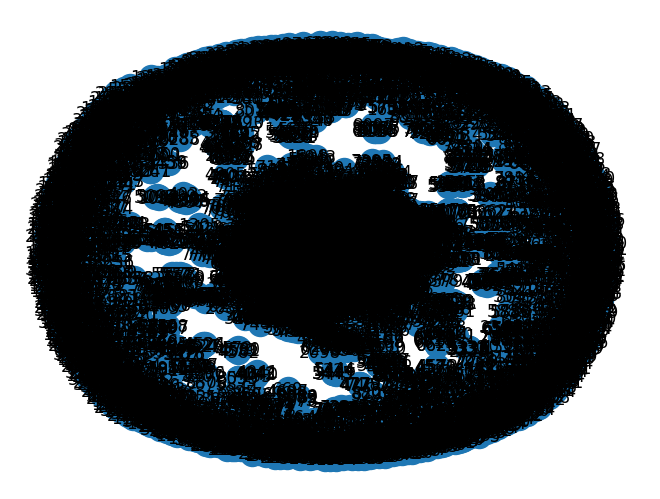

In [24]:

import torch
from torch_geometric.datasets import Planetoid
import networkx as nx
from torch_geometric.utils import to_networkx

# Convert to NetworkX graph
G = to_networkx(data, to_undirected=True)

# Optionally, visualize the graph
import matplotlib.pyplot as plt
nx.draw(G, with_labels=True, node_color=data.y, cmap=plt.get_cmap('Set1'))
plt.show()